# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
import torch.optim as optim



# Preview the dataset

In [3]:
newsgroups = fetch_20newsgroups(
  remove=("headers", "footers", "quotes")
)

texts = newsgroups.data
labels = newsgroups.target
target_names = newsgroups.target_names

print("Number of documents:", len(texts))
print("Number of categories:", len(target_names))

Number of documents: 11314
Number of categories: 20


In [33]:
preview_count = 1
for i in range(preview_count):
  print("="*60)
  print("Category:", target_names[labels[i]])
  print(texts[i][:500])

Category: rec.autos
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


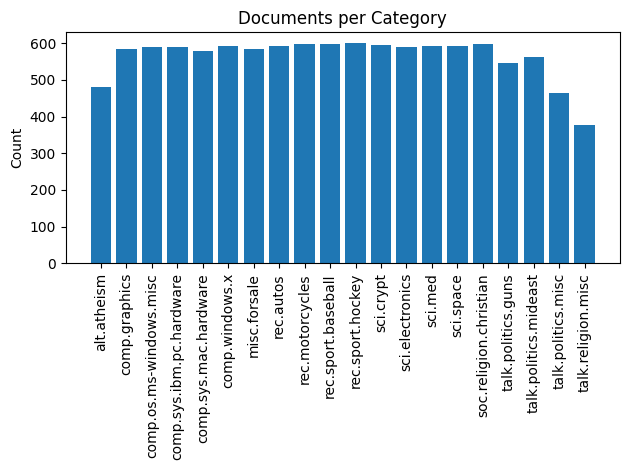

In [34]:

counts = np.bincount(labels)

plt.figure()
plt.bar(range(len(counts)), counts)
plt.xticks(range(len(counts)), target_names, rotation=90)
plt.title("Documents per Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


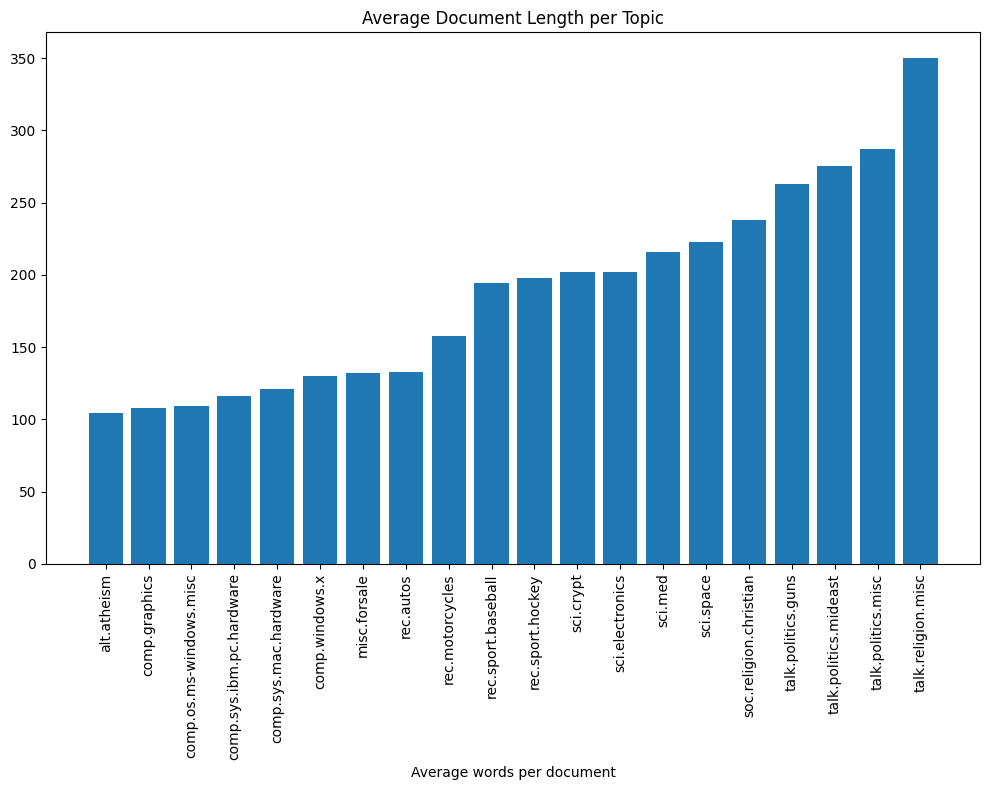

In [35]:
doc_lengths = np.array([len(t.split()) for t in texts])

avg_lengths = []
median_lengths = []
std_lengths = []

for i in range(len(target_names)):
  topic_lengths = doc_lengths[labels == i]
  avg_lengths.append(np.mean(topic_lengths))
  median_lengths.append(np.median(topic_lengths))
  std_lengths.append(np.std(topic_lengths))

avg_lengths = [
  doc_lengths[labels == i].mean()
  for i in range(len(target_names))
]

order = np.argsort(avg_lengths)

plt.figure(figsize=(10, 8))

plt.bar(
  [target_names[i] for i in order],
  np.array(avg_lengths)[order],
)
plt.xticks(range(len(counts)), target_names, rotation=90)

plt.title("Average Document Length per Topic")
plt.xlabel("Average words per document")

plt.tight_layout()
plt.show()

# Basic models

## Split Data


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
  newsgroups.data, newsgroups.target, test_size=0.2 )

## Models - word count

Naive Bayes accuracy: 0.671


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg (Multinomial) accuracy: 0.672
LogReg (OvR) accuracy: 0.691
Decision Tree accuracy: 0.389
Random Forest accuracy: 0.641


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC accuracy: 0.651


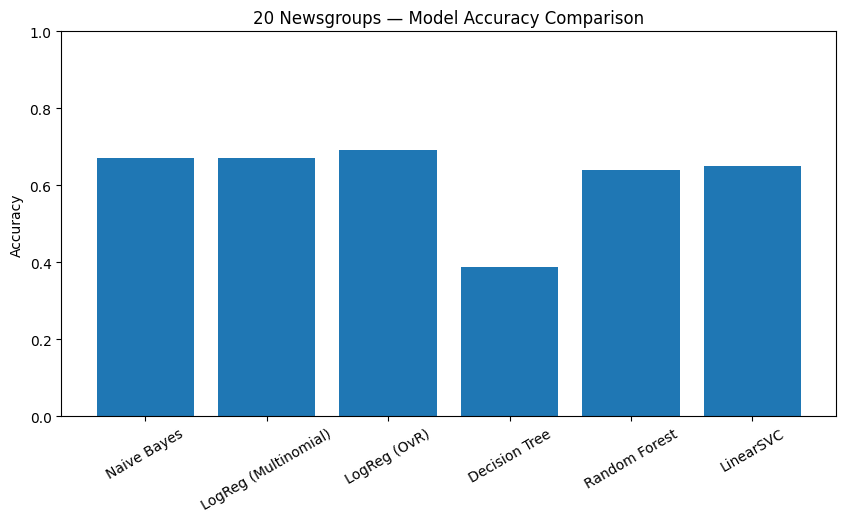

In [39]:
models = {
  "Naive Bayes": MultinomialNB(),
  "LogReg (Multinomial)": LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000),
  "LogReg (OvR)": OneVsRestClassifier(LogisticRegression(max_iter=2000)),
  "Decision Tree": DecisionTreeClassifier(max_depth=50),
  "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=50),
  "LinearSVC": LinearSVC( max_iter=2000),
}

results = {}


for name, clf in models.items():
  pipe = Pipeline([
    ("vec", CountVectorizer(stop_words="english")),
    ("clf", clf)
  ])

  pipe.fit(X_train, y_train)
  pred = pipe.predict(X_test)

  acc = accuracy_score(y_test, pred)
  results[name] = acc
  print(f"{name} accuracy: {acc:.3f}")


plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values())
plt.title("20 Newsgroups — Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.show()

## n-gram

Training Naive Bayes with ngram_range=(1, 1)...
Naive Bayes, ngram (1, 1) accuracy: 0.668
Training Naive Bayes with ngram_range=(1, 2)...
Naive Bayes, ngram (1, 2) accuracy: 0.654
Training Naive Bayes with ngram_range=(2, 2)...
Naive Bayes, ngram (2, 2) accuracy: 0.610
Training LinearSVC with ngram_range=(1, 1)...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC, ngram (1, 1) accuracy: 0.644
Training LinearSVC with ngram_range=(1, 2)...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC, ngram (1, 2) accuracy: 0.659
Training LinearSVC with ngram_range=(2, 2)...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC, ngram (2, 2) accuracy: 0.507


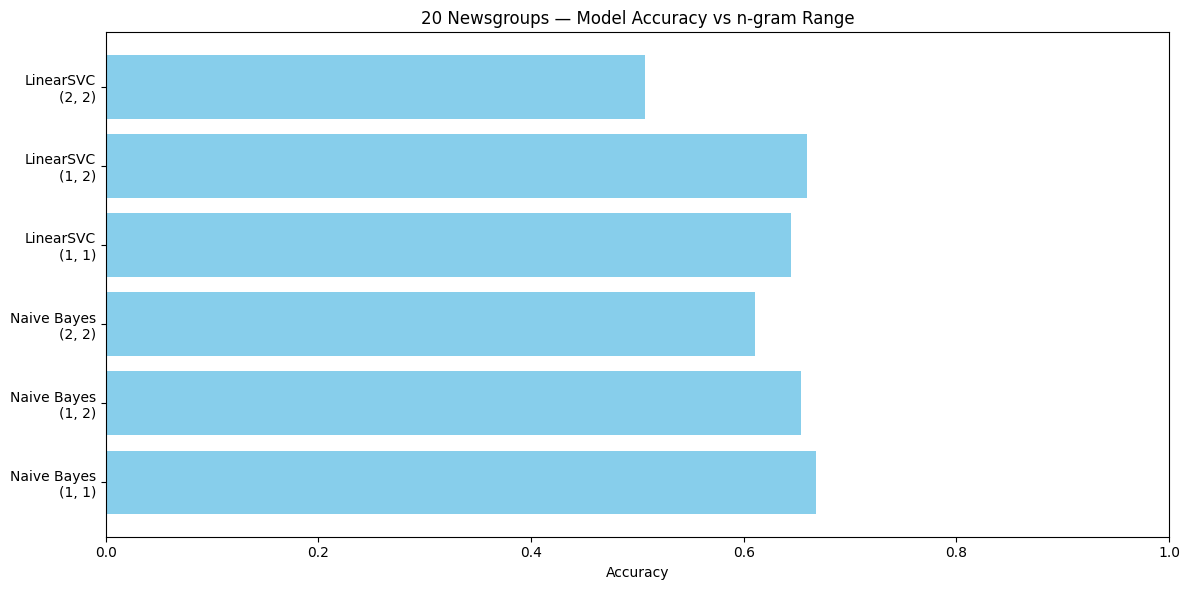

In [5]:
models = {
  "Naive Bayes": MultinomialNB(),
  #"LogReg (OvR)": OneVsRestClassifier(LogisticRegression(max_iter=2000)),
  #"Random Forest": RandomForestClassifier(n_estimators=100, max_depth=50),
  "LinearSVC": LinearSVC( max_iter=2000),
}

ngram_ranges = [(1,1), (1,2), (2,2)]

results = {}

for name, clf in models.items():
  for ngram in ngram_ranges:
    pipe = Pipeline([
      ("vec", CountVectorizer(stop_words="english", ngram_range=ngram)),
      ("clf", clf)
    ])

    print(f"Training {name} with ngram_range={ngram}...")
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)

    results[(name, ngram)] = acc
    print(f"{name}, ngram {ngram} accuracy: {acc:.3f}")


labels = [f"{m}\n{n}" for (m,n) in results.keys()]
values = list(results.values())

plt.figure(figsize=(12,6))
plt.barh(np.arange(len(values)), values, color="skyblue")
plt.yticks(np.arange(len(values)), labels)
plt.xlabel("Accuracy")
plt.title("20 Newsgroups — Model Accuracy vs n-gram Range")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

##  TF-IDF

Naive Bayes accuracy: 0.711
LogReg (OvR) accuracy: 0.738
Random Forest accuracy: 0.627
LinearSVC accuracy: 0.764


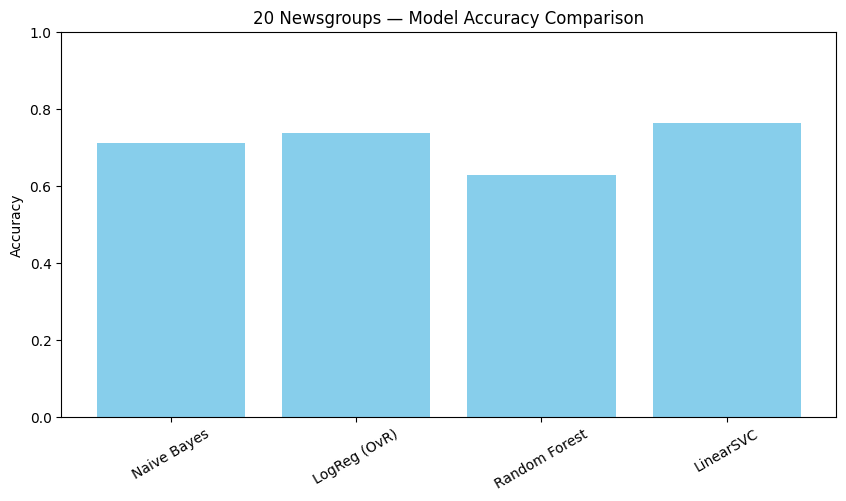

In [6]:
models = {
  "Naive Bayes": MultinomialNB(),
  "LogReg (OvR)": OneVsRestClassifier(LogisticRegression(max_iter=2000)),
  "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=50), #other values perform poorly as well
  "LinearSVC": LinearSVC( max_iter=2000),
}

results = {}


for name, clf in models.items():
  pipe = Pipeline([
    ("vec", TfidfVectorizer(stop_words="english")),
    ("clf", clf)
  ])

  pipe.fit(X_train, y_train)
  pred = pipe.predict(X_test)

  acc = accuracy_score(y_test, pred)
  results[name] = acc
  print(f"{name} accuracy: {acc:.3f}")


plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.title("20 Newsgroups — Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.show()

## grid search TF-IDF params

In [7]:
pipe = Pipeline([
  ("tfidf", TfidfVectorizer(stop_words="english")),
  ("clf", LinearSVC(max_iter=2000))
])

tfidf_param_grid = {
  "tfidf__max_df": [0.8, 0.85, 0.9],
  "tfidf__min_df": [1, 3, 5],
  "tfidf__sublinear_tf": [True, False],
  "tfidf__norm": ["l2", "l1"]
}

grid_tfidf = GridSearchCV(pipe, param_grid=tfidf_param_grid, cv=3, n_jobs=-1, scoring="accuracy")
grid_tfidf.fit(X_train, y_train)

print("Best TF-IDF params:", grid_tfidf.best_params_)
best_tfidf = grid_tfidf.best_estimator_.named_steps["tfidf"]

Best TF-IDF params: {'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}


In [ ]:
print("Best CV accuracy:", grid_tfidf.best_score_)

Best CV accuracy: 0.7406916362832835


## Model grid search

In [8]:
tfidf = TfidfVectorizer(
  stop_words="english",
  max_df=0.8,
  min_df=1,
  sublinear_tf=True,
  norm='l2'
)


models = {
  "Naive Bayes": MultinomialNB(),
  "LogReg (OvR)": OneVsRestClassifier(LogisticRegression(max_iter=2000)),
  "LinearSVC": LinearSVC(max_iter=2000)
}

param_grids = {
  "Naive Bayes": {"clf__alpha": [0.1, 0.5, 1.0]},
  "LogReg (OvR)": {"clf__estimator__C": [0.1, 1, 10]},
  "LinearSVC": {"clf__C": [0.1, 1, 10]}
}

results = {}

for name, clf in models.items():
  pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", clf)
  ])

  grid = GridSearchCV(
    pipe,
    param_grid=param_grids[name],
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
    return_train_score=True
  )

  print(f"\nRunning GridSearchCV for {name}...")
  grid.fit(X_train, y_train)

  results[name] = grid.cv_results_

  for mean_score, params in zip(results[name]['mean_test_score'], results[name]['params']):
    print(f"Params: {params}, CV accuracy: {mean_score:.3f}")

  test_acc = accuracy_score(y_test, grid.predict(X_test))
  print(f"Best params: {grid.best_params_}, Test accuracy: {test_acc:.3f}")


Running GridSearchCV for Naive Bayes...
Params: {'clf__alpha': 0.1}, CV accuracy: 0.735
Params: {'clf__alpha': 0.5}, CV accuracy: 0.709
Params: {'clf__alpha': 1.0}, CV accuracy: 0.691
Best params: {'clf__alpha': 0.1}, Test accuracy: 0.744

Running GridSearchCV for LogReg (OvR)...
Params: {'clf__estimator__C': 0.1}, CV accuracy: 0.642
Params: {'clf__estimator__C': 1}, CV accuracy: 0.728
Params: {'clf__estimator__C': 10}, CV accuracy: 0.741
Best params: {'clf__estimator__C': 10}, Test accuracy: 0.759

Running GridSearchCV for LinearSVC...
Params: {'clf__C': 0.1}, CV accuracy: 0.739
Params: {'clf__C': 1}, CV accuracy: 0.745
Params: {'clf__C': 10}, CV accuracy: 0.735
Best params: {'clf__C': 1}, Test accuracy: 0.769


# Finding keywords

In [9]:
tfidf = TfidfVectorizer(
  stop_words="english",
  max_df=0.8,
  min_df=1,
  sublinear_tf=True,
  norm='l2'
)

X_tfidf = tfidf.fit_transform(X_train)
feature_names = np.array(tfidf.get_feature_names_out())

top_n = 10

for class_index, class_name in enumerate(target_names):

  class_docs = X_tfidf[y_train == class_index]


  mean_tfidf = np.asarray(class_docs.mean(axis=0)).ravel()
  top_features = feature_names[np.argsort(mean_tfidf)[-top_n:][::-1]]

  print(f"Class: {class_name}")
  print("Top keywords:", ", ".join(top_features))
  print("-"*50)

Class: alt.atheism
Top keywords: god, don, people, say, religion, think, atheism, atheists, does, just
--------------------------------------------------
Class: comp.graphics
Top keywords: graphics, thanks, image, files, know, file, 3d, program, need, does
--------------------------------------------------
Class: comp.os.ms-windows.misc
Top keywords: windows, file, dos, files, use, thanks, program, driver, using, problem
--------------------------------------------------
Class: comp.sys.ibm.pc.hardware
Top keywords: drive, card, controller, bus, scsi, ide, pc, thanks, does, drives
--------------------------------------------------
Class: comp.sys.mac.hardware
Top keywords: mac, apple, drive, thanks, problem, quadra, does, know, simms, centris
--------------------------------------------------
Class: comp.windows.x
Top keywords: window, server, motif, use, thanks, widget, application, using, windows, x11r5
--------------------------------------------------
Class: misc.forsale
Top keywor

# Neural network

## Data preparation

In [10]:
tfidf = TfidfVectorizer(
  stop_words="english",
  max_df=0.8,
  min_df=1,
  sublinear_tf=True,
  norm='l2'
)
X = tfidf.fit_transform(X_train + X_test)
y = np.array(list(y_train) + list(y_test))

X_train_tfidf, X_test_tfidf, y_train_nn, y_test_nn = train_test_split(
  X, y, test_size=0.25, stratify=y
)
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)


## Simple NN

In [11]:
input_dim = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train_nn))

model = nn.Sequential(
  nn.Linear(input_dim, 128),
  nn.ReLU(),
  nn.Dropout(0.3),
  nn.Linear(128, num_classes)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
batch_size = 64

for epoch in range(num_epochs):
  permutation = torch.randperm(X_train_tensor.size(0))
  epoch_loss = 0

  for i in range(0, X_train_tensor.size(0), batch_size):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
    optimizer.zero_grad()
    outputs = model(batch_x)
    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

with torch.no_grad():
  outputs = model(X_test_tensor)
  _, predicted = torch.max(outputs, 1)
  accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

print(f"Test accuracy: {accuracy:.3f}")

Epoch 1/10, Loss: 371.4140
Epoch 2/10, Loss: 229.9732
Epoch 3/10, Loss: 119.9368
Epoch 4/10, Loss: 68.9789
Epoch 5/10, Loss: 44.3215
Epoch 6/10, Loss: 31.2690
Epoch 7/10, Loss: 24.3889
Epoch 8/10, Loss: 20.2579
Epoch 9/10, Loss: 17.8265
Epoch 10/10, Loss: 16.3146
Test accuracy: 0.763
